### Using soundfile to extract .wav file

In [1]:
from soundfile import SoundFile as sf
from collections import namedtuple
import matplotlib.pyplot as pp
import scipy.signal
import scipy
import numpy as np

filepath = "./BnK_data/20200327-095410(UTC)-200327_AnechoicChamber_0degrees_seq1_v1-0000872342.wav"

In [2]:
# sf_attributes = ["channels", "closed", "endian", "extra_info", "format", "format_info", "frames", "mode", "name", "samplerate", "sections", "subtype", "subtype_info"]
def extract_wav(filepath):
    params_tuple = namedtuple('params',['channels','file_format','nframes','samplerate','name'])
    with sf(filepath) as wavfile:
        data = wavfile.read()
        params = params_tuple(
            channels = wavfile.channels,
            file_format = wavfile.format,
            nframes = wavfile.frames,
            samplerate = wavfile.samplerate,
            name = wavfile.name)
    return data, params

In [3]:
data, params = extract_wav(filepath)
params.samplerate

65536

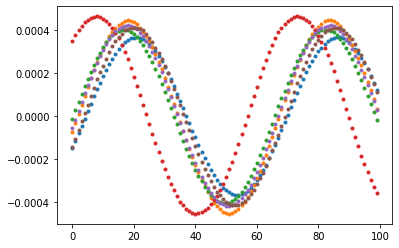

In [4]:
data_snip = data[499990:1000000,:]
pp.plot(data_snip[0:100,:],'.')

## Sandbox for arlpy python module

In [5]:
import arlpy

In [6]:
help(arlpy.bf.normalize)
help(arlpy.bf.delay_and_sum)

Help on function normalize in module arlpy.bf:

normalize(x, unit_variance=True)
    Normalize array timeseries data to be zero-mean and equal variance.
    
    The average signal power across the array is retained if `unit_variance`
    is set to True so that the beamformed data can be compared with other datsets.
    
    :param x: passband real timeseries data for multiple sensors (row per sensor)
    :param unit_variance: True to make timeseries unit variance,
                          False to retain average signal power across the array
    :returns: normalized passband real timeseries data

Help on function delay_and_sum in module arlpy.bf:

delay_and_sum(x, fs, sd, shading=None)
    Time-domain delay-and-sum beamformer.
    
    The array data must be 2D with timeseries for each sensor in
    individual rows. The steering delays must also be 2D with a row per
    steering direction.
    
    :param x: passband real timeseries data for multiple sensors (row per sensor)
    :par

In [7]:
help(arlpy.bf.steering_plane_wave)

Help on function steering_plane_wave in module arlpy.bf:

steering_plane_wave(pos, c, theta)
    Compute steering delays assuming incoming signal has a plane wavefront.
    
    For linear arrays, pos is 1D array. For planar and 3D arrays, pos is a 2D array with a
    sensor position vector in each row.
    
    For linear arrays, theta is a 1D array of angles (in radians) with 0 being broadside. For
    planar and 3D arrays, theta is a 2D array with an (azimuth, elevation) pair in each row.
    Such arrays can be easily generated using the :func:`arlpy.utils.linspace2d` function.
    
    The broadside direction is along the x-axis of a right-handed coordinate system with z-axis pointing
    upwards, and has azimuth and elevation as 0. In case of linear arrays, the y-coordinate is the
    sensor position. In case of planar arrays, if only 2 coordinates are provided, these coordinates
    are assumed to be y and z.
    
    :param pos: sensor positions (m)
    :param c: signal propagat

In [8]:
theta = 0
steering_delay = arlpy.bf.steering_plane_wave(np.array([-0.125,-0.075,-0.025,0.025,0.075,0.125]),343,theta)
print(steering_delay)
y = arlpy.bf.delay_and_sum(data_snip.transpose(),params.samplerate,steering_delay)

[[ 0.  0.  0. -0. -0. -0.]]


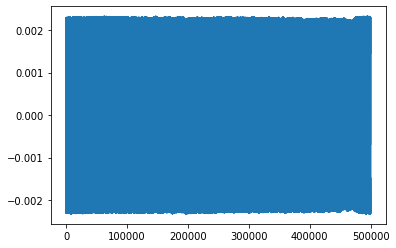

In [9]:
pp.plot(y.flatten())

In [10]:
# Power (mean square of beamformed signal)
np.mean(y**2)

2.600352184095921e-06

### Iterate over angles to generate beampattern

### Finding local maxima

In [11]:
def find_maximas(data : '1D numpy array') -> 'numpy array of "bool"':
    # Check if sample is greater than or equal to 2 samples to the left and two samples to the right
    maximas_map = np.r_[data[2:] <= data[:-2],False,False] &\
                np.r_[data[1:] <= data[:-1],False] &\
                np.r_[False,data[:-1] <= data[1:]] &\
                np.r_[False,False,data[:-2] <= data[2:]]
    # When a local maxima occurs twice consecutively, only count the first one
    maximas_map = maximas_map & np.diff(np.r_[False,maximas_map])
    # Remove outliers
    maximas_index = np.where(maximas_map)[0]
    maximas_spacing = np.diff(maximas_index)
    outliers_map = np.r_[True ,abs(maximas_spacing - np.mean(maximas_spacing)) < 5 * np.std(maximas_spacing)] # filter out outliers outside five standard deviations
    maximas_index = maximas_index[outliers_map]
    # Find values
    maximas_values = data[maximas_index]
    return np.array([maximas_index, maximas_values])

def find_minimas(data : '1D numpy array') -> 'numpy array of "bool"':
    # Check if sample is less than or equal to 2 samples to the left and two samples to the right
    minimas_map = np.r_[data[2:] >= data[:-2],False,False] &\
                np.r_[data[1:] >= data[:-1],False] &\
                np.r_[False,data[:-1] >= data[1:]] &\
                np.r_[False,False,data[:-2] >= data[2:]]
    # When a local minima occurs twice consecutively, only count the first one
    minimas_map = minimas_map & np.diff(np.r_[False,minimas_map])
    # Remove outliers
    minimas_index = np.where(minimas_map)[0]
    minimas_spacing = np.diff(minimas_index)
    outliers_map = np.r_[True ,abs(minimas_spacing - np.mean(minimas_spacing)) < 5 * np.std(minimas_spacing)] # filter out outliers outside five standard deviations
    minimas_index = minimas_index[outliers_map]
    # Find values
    minimas_values = data[minimas_index]
    return np.array([minimas_index, minimas_values])

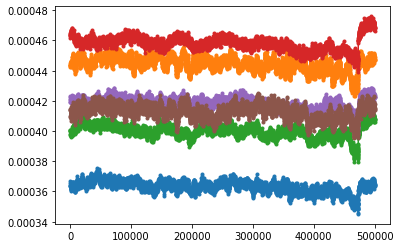

In [12]:
# finding minimas and maximas over each are, there are some wich are counted twice,
maximas = []
minimas = []
for i in range(6):
    maximas.append(find_maximas(data_snip[:,i]))
    minimas.append(find_minimas(data_snip[:,i]))
    pp.plot(maximas[i][0],maximas[i][1],marker = '.')
# pp.ylim(bottom=0)
# pp.plot(np.diff(maximas[0][0]))
# pp.xlim((110,115))
# pp.plot(maximas[0][0][100:130],maximas[0][1][100:130])

7425.0 7492.0


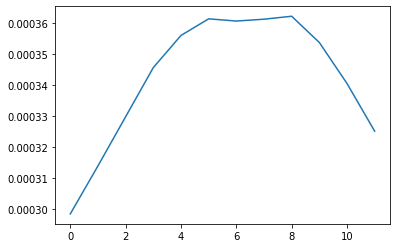

In [13]:
print(maximas[0][0][113],maximas[0][0][114])
pp.plot(data_snip[7420:7432,0])

(0.0, 100.0)

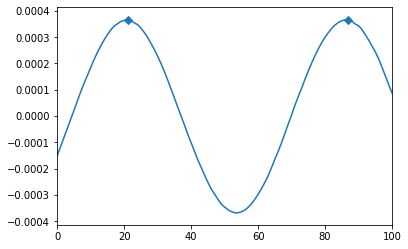

In [14]:
# scipy.signal.argrelextrema can be used to find local maxima, however error is introduced since it only compares samples with their immediate neighbors
import scipy.signal as signal

channel = 0

maximums = signal.argrelextrema(data_snip[:,channel], np.greater)
pp.plot(data_snip[:,channel],'-D',markevery=list(maximums[0]))
pp.xlim((0,100))

### Use local maxima and minima to calculate the calibration required for each transducer

7630
7630
7630
7630
7630


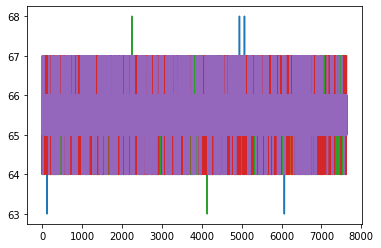

In [15]:
for i in range(5):
    pp.plot(np.diff(maximas[i][0]))
    print(maximas[i][0].size)

array([ 0.        ,  2.31917683,  3.70454843, 13.02189016,  2.56494953,
        0.60414209])

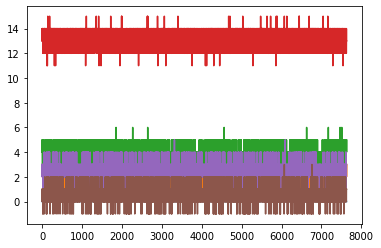

In [16]:
a = []
average_delay = np.zeros(6)
for j in range(6):
    for i in range(maximas[0][0].size-1):
        a.append(maximas[0][0,i]-maximas[j][0,i])
    average_delay[j] = np.average(a)
    pp.plot(a)
    a = []
average_delay

(0.0, 100.0)

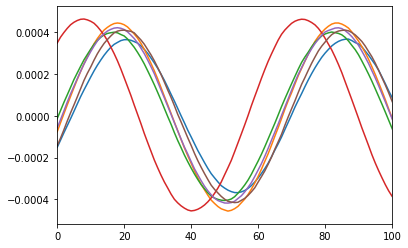

In [17]:
pp.plot(data_snip)
pp.xlim((0,100))

In [18]:
amplitude = []
for i in range(6):
    amplitude.append(np.average(maximas[i][1]) - np.average(minimas[i][1]))
print(amplitude)

[0.0007271844992909741, 0.0008893973706459266, 0.0007986549973358854, 0.0009116372556898782, 0.000836351214660641, 0.0008247052028402461]


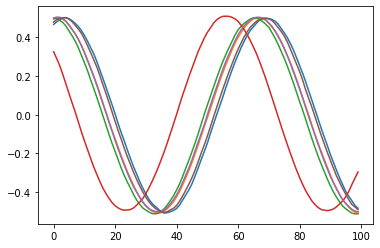

In [19]:
data_snip_amp_normalised = np.zeros(data_snip.shape)
for i in range(6):
    data_snip_amp_normalised[:,i] = data_snip[:,i]/amplitude[i]
pp.plot(data_snip_amp_normalised[1000:1100])

(0.0, 0.002)

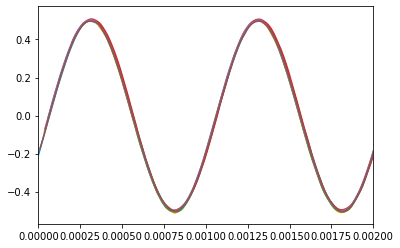

In [20]:
time_instances = np.linspace(0,data_snip.shape[0]/params.samplerate,data_snip.shape[0])
for i in range(6):
    pp.plot(time_instances + average_delay[i]/params.samplerate,data_snip_amp_normalised[:,i])
pp.xlim((0,0.002))